<a href="https://colab.research.google.com/github/RonaldCedeno/LSTM-Freezing_Of_Gait/blob/main/LSTM_FoG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long Short-Term Memory (LSTM) Neural Network 

Dataset: Daphnet - Freezing of Gait

Attribute information:
- Time of sample in millisecond
- Ankle (shank) acceleration - horizontal forward acceleration [mg] (```Ak_hf```)
- Ankle (shank) acceleration - vertical [mg] (```Ak_ve```)
- Ankle (shank) acceleration - horizontal lateral [mg] (```Ak_hl```)
- Upper leg (thigh) acceleration - horizontal forward acceleration [mg] (```Ul_hf```)
- Upper leg (thigh) acceleration - vertical [mg] (```Ul_ve```)
- Upper leg (thigh) acceleration - horizontal lateral [mg] (```Ul_hl```)
- Trunk acceleration - horizontal forward acceleration [mg] (```Tr_hf```)
- Trunk acceleration - vertical [mg] (```Tr_ve```)
- Trunk acceleration - horizontal lateral [mg] (```Tr_hl```)

# Libraries

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

from time import time

# Review data (1 file)

In [ ]:
df = pd.read_csv('dataset/S03R01.txt', header=None, sep=' ')

In [ ]:
names = ['Time',
         'Ak_hf','Ak_ve','Ak_hl',
         'Ul_hf','Ul_ve','Ul_hl',
         'Tr_hf','Tr_ve','Tr_hl',
         'Label']

df.columns = names

In [ ]:
df.shape

(144190, 11)

In [ ]:
df.head()

,Time,Ak_hf,Ak_ve,Ak_hl,Ul_hf,Ul_ve,Ul_hl,Tr_hf,Tr_ve,Tr_hl,Label
0,15,80,49,-980,0,0,0,0,0,0,0
1,31,80,49,-980,0,0,0,0,0,0,0
2,46,50,58,-960,0,0,0,0,0,0,0
3,62,50,58,-960,0,0,0,0,0,0,0
4,78,50,58,-960,0,0,0,0,0,0,0


- Actual label:
  - 0: Not part of the experiment
  - 1: No FoG
  - 2: FoG

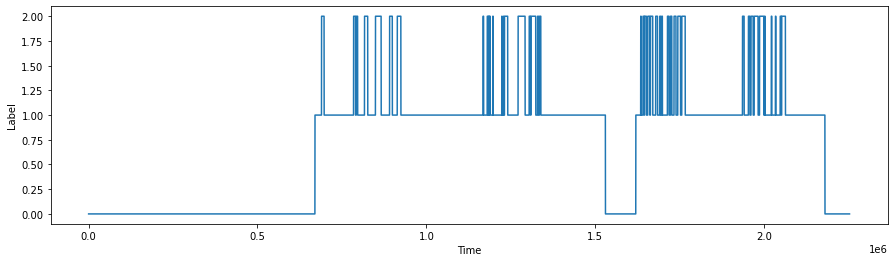

In [ ]:
"""Label status is shown throughout a sample file"""

fig,ax = plt.subplots(figsize=(15,4))
_ = sns.lineplot(data=df, x="Time", y='Label', ax=ax)

Since label 0 is not part of the experimental protocol, it will not be considered for the study of the presence of FoG episodes.

**Setting new label for binary classification**
- New label:
  - 0: No FoG
  - 1: FoG

In [ ]:
df = df[df['Label'] != 0]

In [ ]:
df['Label'] = df['Label'].replace(1,0)

<ipython-input-11-314c77574127>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = df['Label'].replace(1,0)


In [ ]:
df['Label'] = df['Label'].replace(2,1)

<ipython-input-12-78e0ea893eda>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = df['Label'].replace(2,1)


Graphing the behavior of the data

In [ ]:
def graph_data(dataframe_name, attributes, hue_label='Label'):
  fig,axs = plt.subplots(9,1,figsize=(15,15))
  for i, att in enumerate(attributes):
    _ = sns.lineplot(data=dataframe_name, x=dataframe_name.index, y=att, ax=axs[i], hue=hue_label)

In [ ]:
"""Getting only the name of the attributes"""
attributes = names[1:-1]

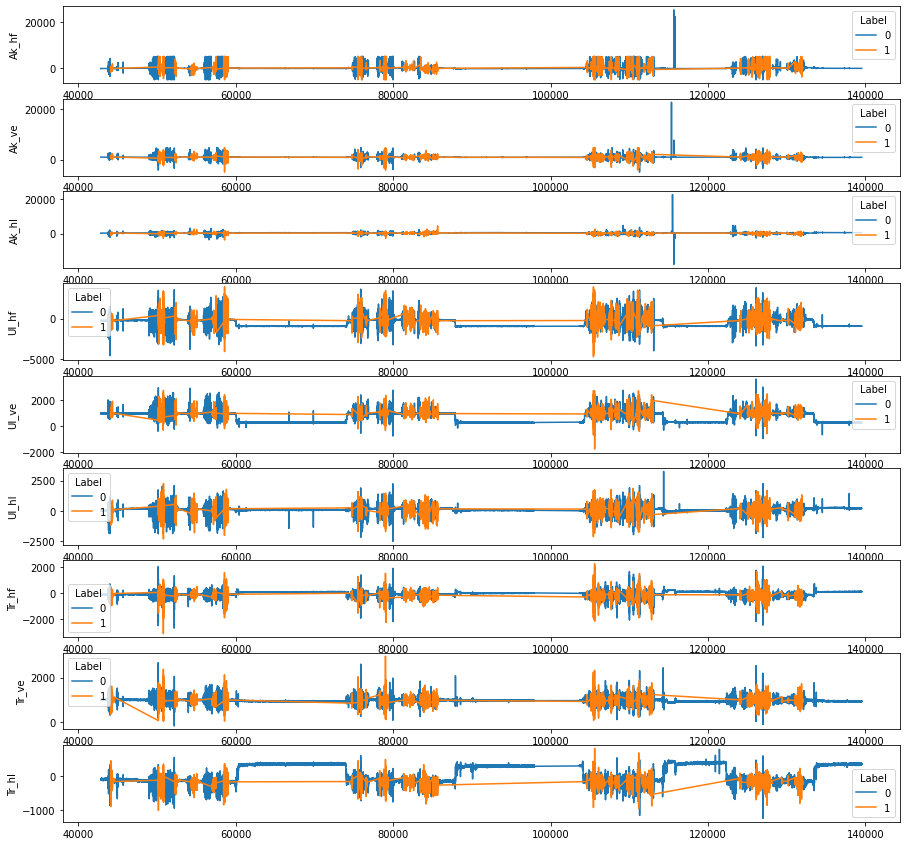

In [ ]:
graph_data(df, attributes)

Considering that each file is going to be unified, the time (x axis) will be directly the indexes, remembering that the separation of the data is 16ms

In [ ]:
df.reset_index(drop=True, inplace=True)
df = df.iloc[:,1:]

# Data preparation

All files will be read and merged to get a complete dataset. Some variables created above will be used

In [ ]:
df_fog = [pd.read_csv(file, header=None, sep=' ') for file in Path('dataset').iterdir()]
df_fog = pd.concat(df_fog)

In [ ]:
df_fog.columns = names

In [ ]:
df_fog = df_fog[df_fog['Label'] != 0]

In [ ]:
df_fog['Label'] = df_fog['Label'].replace(1,0)

<ipython-input-20-bcb9b1646b69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fog['Label'] = df_fog['Label'].replace(1,0)


In [ ]:
df_fog['Label'] = df_fog['Label'].replace(2,1)

<ipython-input-21-0c006372b4d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fog['Label'] = df_fog['Label'].replace(2,1)


In [ ]:
df_fog.reset_index(drop=True, inplace=True)
df_fog = df_fog.iloc[:,1:]

In [ ]:
df_fog.shape

(1140835, 10)

In [ ]:
df_fog.head()

,Ak_hf,Ak_ve,Ak_hl,Ul_hf,Ul_ve,Ul_hl,Tr_hf,Tr_ve,Tr_hl,Label
0,-90,1000,257,-245,962,10,-135,1019,-87,0
1,-70,1000,247,-254,944,40,-116,990,-97,0
2,-70,990,267,-245,972,50,-126,1009,-87,0
3,-80,1009,287,-254,962,50,-126,1019,-97,0
4,-70,1009,257,-245,953,30,-116,1000,-77,0


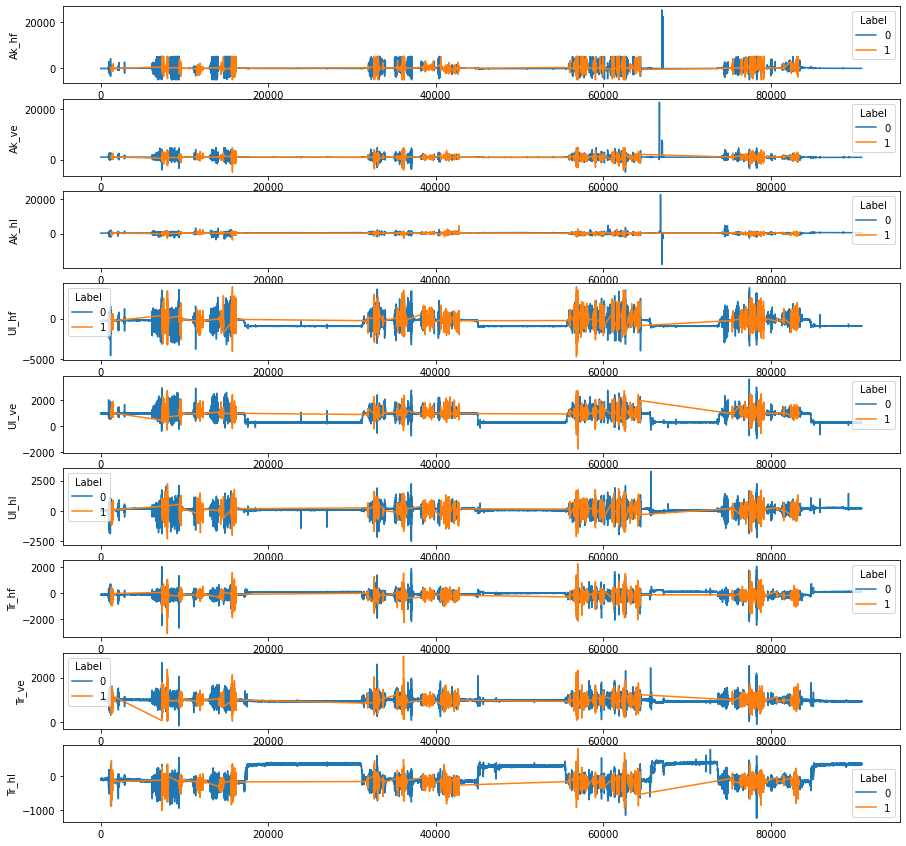

In [ ]:
graph_data(df, attributes)

Since the data contains certain extreme data, it will be deleted and the indexes reset to have a correct continuity in the data

In [ ]:
q1_data = []
q3_data = []
iqr_data = []

mean_attribute_data = []

for attr in attributes:
  q3 = df_fog[attr].quantile(0.75)
  q1 = df_fog[attr].quantile(0.25)
  iqr = q3 - q1

  non_extreme = df_fog[
      (df_fog[attr] < (q3 + 1.5*iqr)) & (df_fog[attr] > (q1 - 1.5*iqr))
    ]

  mean_attribute = round(non_extreme[attr].mean())

  '''Adding values to lists'''
  q1_data.append(q1)
  q3_data.append(q3)
  iqr_data.append(iqr)

  mean_attribute_data.append(mean_attribute)
  ''''''

  extreme = df_fog[
      (df_fog[attr] > (q3 + 1.5*iqr)) | (df_fog[attr] < (q1 - 1.5*iqr))
    ]

  df_fog[attr].replace(
      to_replace=extreme[attr].unique(), 
      value=mean_attribute, 
      inplace=True
      )

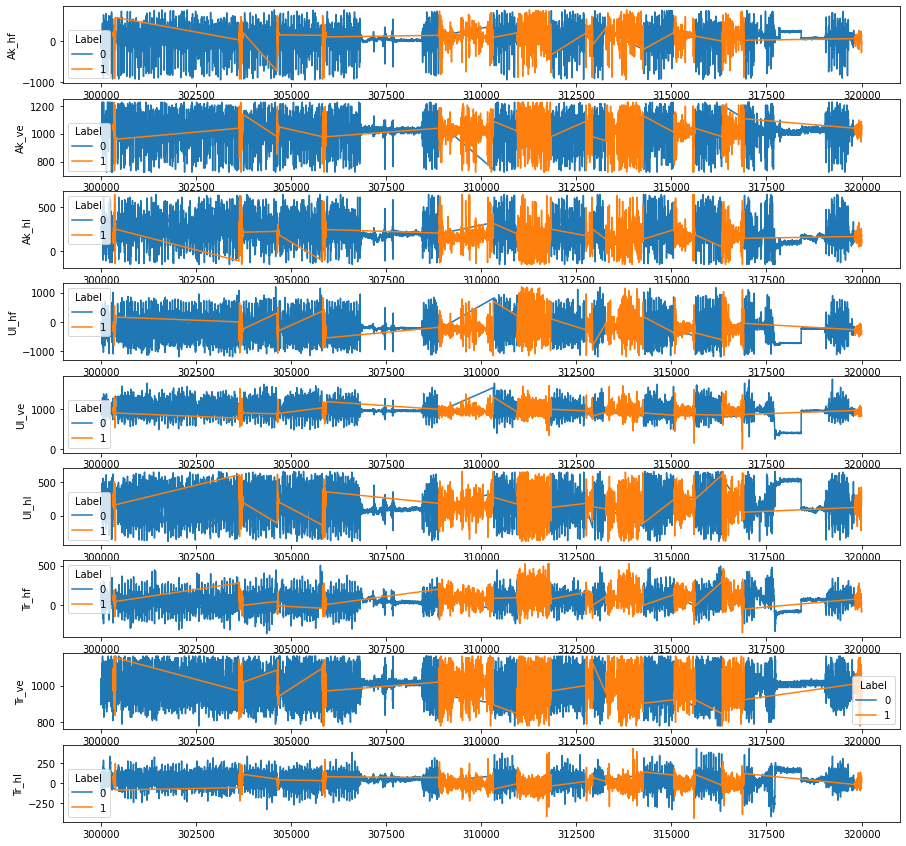

In [ ]:
graph_data(df_fog[300000:320000], attributes)

Checking data correlation to reduce the number of attributes

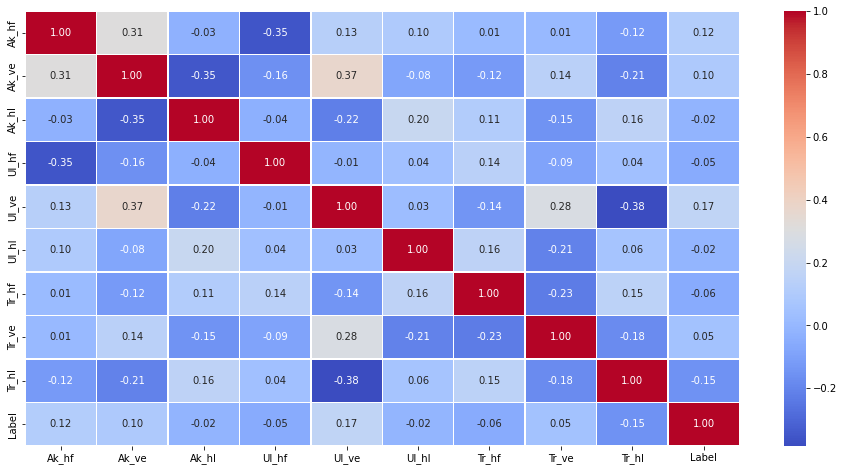

In [ ]:
corr_matrix = df_fog.corr(method='spearman')
fig,ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

There is no high correlation in each of the variables, so the number of columns will keep up

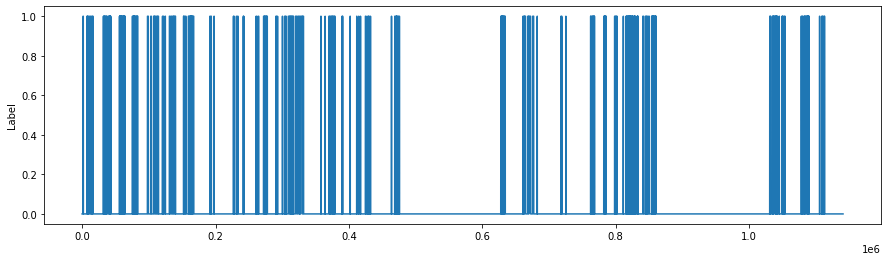

In [ ]:
"""
Status of labels for the entire dataset:
- 0: No FoG
- 1: FoG
"""

fig,ax = plt.subplots(figsize=(15,4))
_ = sns.lineplot(data=df_fog, x=df_fog.index, y='Label', ax=ax)

# Training and Validation Set

In [ ]:
train_total = round(len(df_fog) * 0.80)
test_total = round(len(df_fog) * 0.20)

print("Total de datos: {}".format(len(df_fog)))
print("Cantidad de datos para train: {}".format(train_total))
print("Cantidad de datos para test: {}".format(test_total))

Total de datos: 1140835
Cantidad de datos para train: 912668
Cantidad de datos para test: 228167


In [ ]:
train = df_fog.iloc[:train_total]
test = df_fog.iloc[train_total:]

In [ ]:
train.shape

(912668, 10)

In [ ]:
test.shape

(228167, 10)

A window of T-values (Value of time_step) will be used, so the last data that is not used in the training will be implemented in the test

In [ ]:
time_step = 30

last_train = train.iloc[-(time_step-1):]
test = pd.concat([last_train, test], axis=0)

In [ ]:
"""
Al momento de comparar la predicción con el valor real, 
se remueve (time_step - 1) valores iniciales de df_test_sc.
Esto se encuentra removido en test_x más adelante.
"""
test.shape

(228196, 10)

In [ ]:
train_x = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_x = test.iloc[:,:-1]
test_y = test.iloc[time_step-1:,-1]

In [ ]:
(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

((912668, 9), (912668,), (228196, 9), (228167,))

# Escalando datos

In [ ]:
sc = MinMaxScaler(feature_range=(-1,1))
train_x_sc = sc.fit_transform(train_x)

In [ ]:
test_x_sc = sc.transform(test_x)

In [ ]:
(train_x_sc.shape, test_x_sc.shape)

((912668, 9), (228196, 9))

### Formando **dataframes escalados** con Tiempo y Etiqueta (Solo con motivos de gráficas)

In [ ]:
train_x.columns

Index(['Ak_hf', 'Ak_ve', 'Ak_hl', 'Ul_hf', 'Ul_ve', 'Ul_hl', 'Tr_hf', 'Tr_ve',
       'Tr_hl'],
      dtype='object')

In [ ]:
train_x_sc.shape

(912668, 9)

In [ ]:
# Training
df_train_sc = pd.DataFrame(train_x_sc, 
                          columns = train_x.columns)
df_train_sc = pd.concat([df_train_sc, train_y], axis=1)

In [ ]:
df_train_sc.shape

(912668, 10)

In [ ]:
df_train_sc.head()

,Ak_hf,Ak_ve,Ak_hl,Ul_hf,Ul_ve,Ul_hl,Tr_hf,Tr_ve,Tr_hl,Label
0,0.001179,0.100,0.024020,-0.204167,0.231066,-0.243503,-0.391667,0.254593,-0.191667,0
1,0.024764,0.100,-0.001264,-0.211667,0.213700,-0.185756,-0.352083,0.102362,-0.212500,0
2,0.024764,0.060,0.049305,-0.204167,0.240714,-0.166506,-0.372917,0.202100,-0.191667,0
3,0.012972,0.136,0.099874,-0.211667,0.231066,-0.166506,-0.372917,0.254593,-0.212500,0
4,0.024764,0.136,0.024020,-0.204167,0.222383,-0.205005,-0.352083,0.154856,-0.170833,0


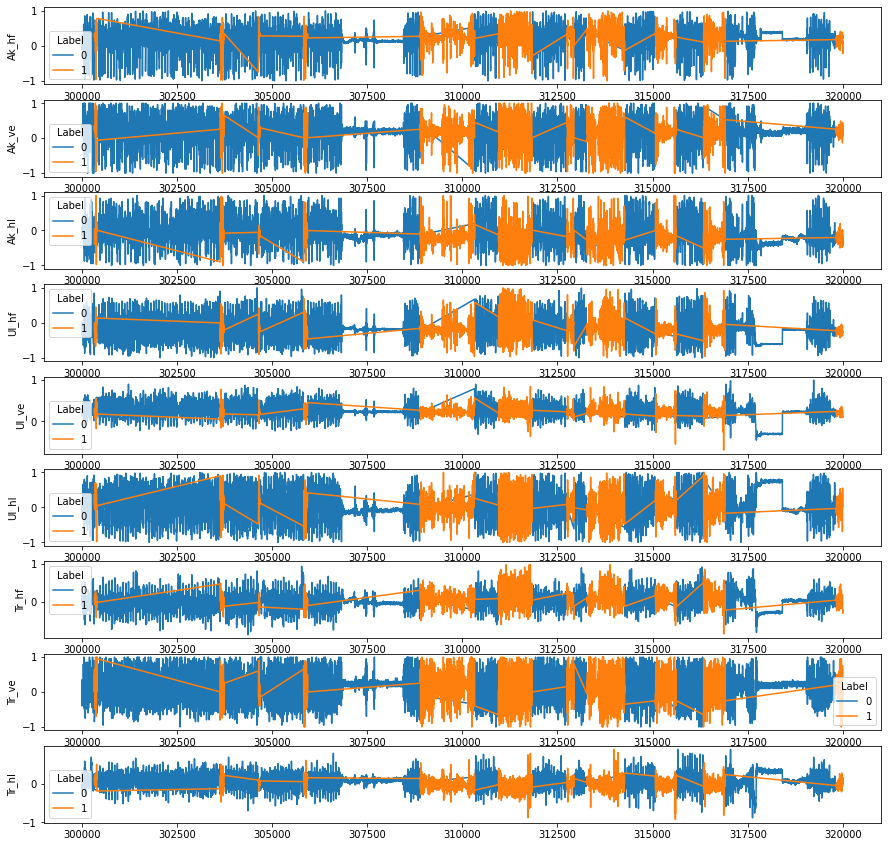

In [ ]:
graph_data(df_train_sc[300000:320000], attributes)

In [ ]:
# Testing
df_test_sc = pd.DataFrame(test_x_sc, 
                          columns = test_x.columns)
df_test_sc = df_test_sc.iloc[time_step-1:,:].reset_index(drop=True)
df_test_sc = pd.concat([df_test_sc, test_y.reset_index(drop=True)], axis=1)

In [ ]:
df_test_sc.shape

(228167, 10)

In [ ]:
df_test_sc.head()

,Ak_hf,Ak_ve,Ak_hl,Ul_hf,Ul_ve,Ul_hl,Tr_hf,Tr_ve,Tr_hl,Label
0,-0.511792,-0.372,-0.201011,0.681667,-0.287024,-0.611165,0.354167,0.002625,0.191667,0
1,-0.500000,-0.372,-0.150442,0.681667,-0.277376,-0.630414,0.312500,0.102362,0.191667,0
2,-0.523585,-0.372,-0.175727,0.689167,-0.295707,-0.630414,0.333333,0.102362,0.231250,0
3,-0.500000,-0.372,-0.175727,0.681667,-0.287024,-0.630414,0.312500,0.154856,0.191667,0
4,-0.500000,-0.372,-0.125158,0.681667,-0.295707,-0.611165,0.354167,0.102362,0.210417,0


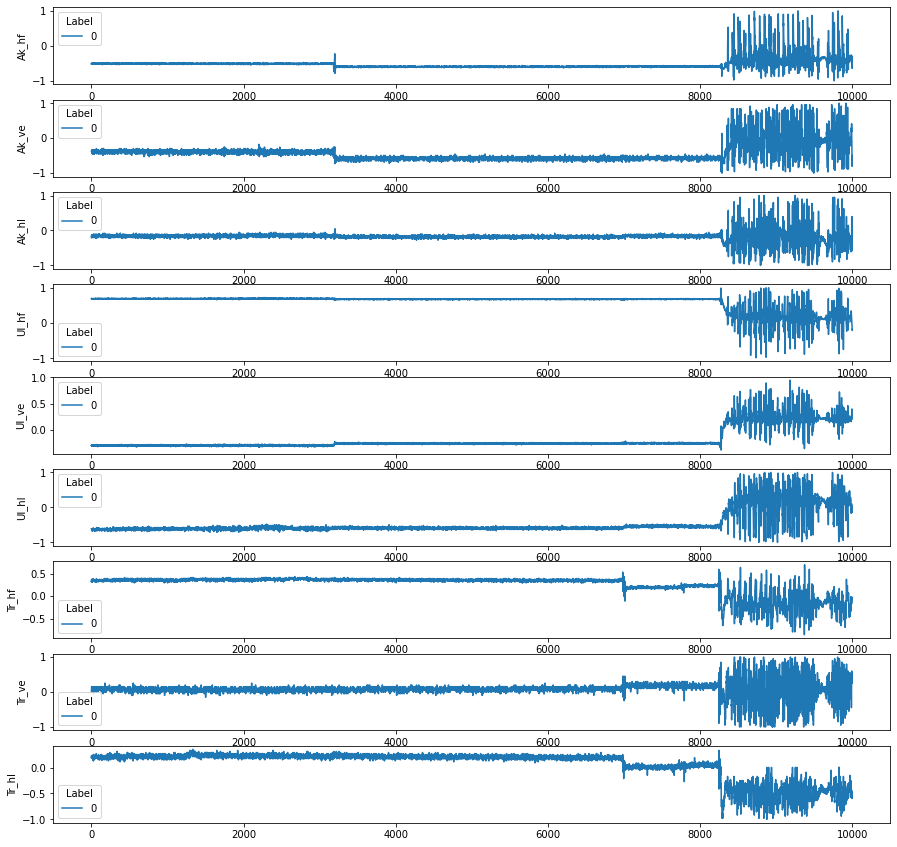

In [ ]:
graph_data(df_test_sc[:10000], attributes)

# Preparing training and testing data for the LSTM model

In [ ]:
# Training dataset
x_train = []
y_train = []

for i in range(time_step, train_y.shape[0]):
  x_train.append(train_x_sc[i-time_step:i]) 
  y_train.append(train_y[i-1])

x_train, y_train = np.array(x_train), np.array(y_train)
y_train = np.expand_dims(y_train, axis=1)

In [ ]:
# Testing dataset
x_test = []
y_test = []

for i in range(time_step, test_y.shape[0]):
  x_test.append(test_x_sc[i-time_step:i]) # Ej. Para el primer dato [0,30)
  y_test.append(test_y.values[i-1]) # Ej. Salida es la etiqueta 0 o 1

x_test, y_test = np.array(x_test), np.array(y_test)
y_test = np.expand_dims(y_test, axis=1)

In [ ]:
(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

((912638, 30, 9), (912638, 1), (228137, 30, 9), (228137, 1))

# LSTM Model

In [7]:
# List of constants for the model
LAYERS = [8, 8, 8, 1]                # Unit numbers for hidden layers and output layer
M_TRAIN = x_train.shape[0]           # Number of training samples (2D)
M_TEST = x_test.shape[0]             # Number of test samples (2D)
N = x_train.shape[2]                 # Number of features
BATCH = 300                          # Batch Size
EPOCH = 10                           # Number of epochs
LR = 5e-2                            # Learning Rate - SGD
LAMBD = 3e-2                         # Lambda in L2 regularization
DP = 0.0                             # Dropout Rate
RDP = 0.0                            # Recurrent Dropout Rate

In [4]:
model = Sequential()

model.add(LSTM(input_shape=(time_step, N), 
               units=LAYERS[0],
               activation='tanh', 
               recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), 
               recurrent_regularizer=l2(LAMBD),
               dropout=DP, 
               recurrent_dropout=RDP,
               return_sequences=True, 
               return_state=False,
               stateful=False, 
               unroll=False
              ))

model.add(BatchNormalization())

model.add(LSTM(units=LAYERS[1],
               activation='tanh', 
               recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), 
               recurrent_regularizer=l2(LAMBD),
               dropout=DP, 
               recurrent_dropout=RDP,
               return_sequences=True, 
               return_state=False,
               stateful=False, 
               unroll=False
              ))

model.add(BatchNormalization())

model.add(LSTM(units=LAYERS[2],
               activation='tanh', 
               recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), 
               recurrent_regularizer=l2(LAMBD),
               dropout=DP, 
               recurrent_dropout=RDP,
               return_sequences=False, 
               return_state=False,
               stateful=False, 
               unroll=False
              ))

model.add(BatchNormalization())

model.add(Dense(units=LAYERS[3], activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=LR))

In [ ]:
# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Saving best model
saving_model = ModelCheckpoint("model_fog.h5", save_best_only=True)

In [ ]:
x_train.shape

(912638, 30, 9)

In [3]:
start = time()

history = model.fit(x_train, 
          y_train,
          epochs=EPOCH,
          batch_size=BATCH,
          validation_split=0.0,
          validation_data=(x_test[:M_TEST], y_test[:M_TEST]),
          callbacks=[lr_decay, early_stop, saving_model])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

In [2]:
# Evaluating model
train_loss, train_acc = model.evaluate(x_train, 
                                       y_train,
                                       batch_size=M_TRAIN, 
                                       verbose=1)

test_loss, test_acc = model.evaluate(x_test[:M_TEST], 
                                     y_test[:M_TEST],
                                     batch_size=M_TEST, 
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

In [1]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()